Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Train loss: 1.71, Accuracy: 37.01%, Validation loss: 1.42, Validation Accuracy: 48.65%
Epoch 2, Train loss: 1.35, Accuracy: 51.42%, Validation loss: 1.29, Validation Accuracy: 53.90%


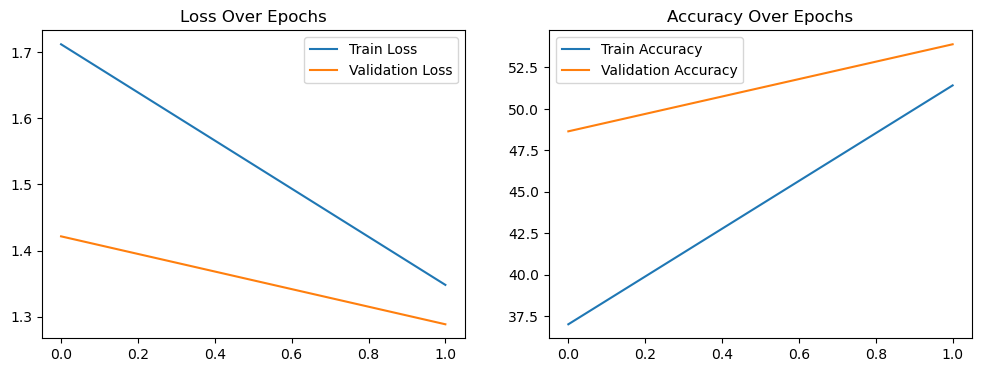

              precision    recall  f1-score   support

       plane       0.49      0.69      0.57      1000
         car       0.61      0.76      0.68      1000
        bird       0.38      0.55      0.45      1000
         cat       0.42      0.36      0.39      1000
        deer       0.46      0.44      0.45      1000
         dog       0.56      0.37      0.44      1000
        frog       0.61      0.62      0.62      1000
       horse       0.79      0.50      0.61      1000
        ship       0.59      0.65      0.62      1000
       truck       0.64      0.46      0.53      1000

    accuracy                           0.54     10000
   macro avg       0.56      0.54      0.54     10000
weighted avg       0.56      0.54      0.54     10000



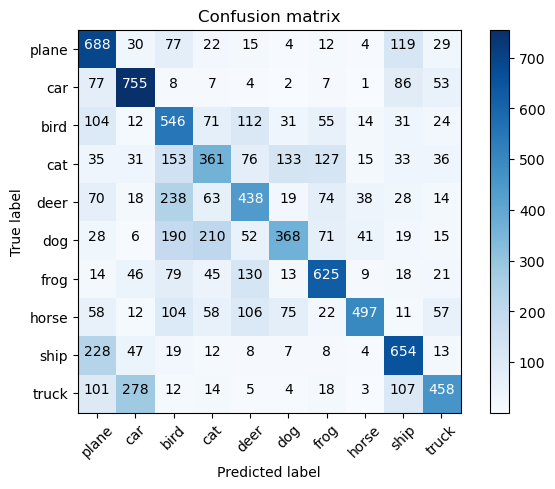

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, classification_report

# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4, shuffle=False)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = SimpleCNN()

# Set up the training
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Function to plot training progress
def plot_training(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Train the network and save history for plotting
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(2):  # loop over the dataset multiple times
    train_loss, valid_loss = 0.0, 0.0
    correct, total = 0, 0
    
    # Training loop
    net.train()
    for data in trainloader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validation loop
    net.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Saving history for plots
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(100 * correct / total)
    history['val_loss'].append(valid_loss / len(testloader))
    history['val_acc'].append(100 * val_correct / val_total)

    print(f'Epoch {epoch+1}, Train loss: {train_loss / len(trainloader):.2f}, Accuracy: {100 * correct / total:.2f}%, Validation loss: {valid_loss / len(testloader):.2f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%')

plot_training(history)

# Testing the network and plotting confusion matrix
y_pred = []
y_true = []
net.eval()
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Classification Report
print(classification_report(y_true, y_pred, target_names=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']))


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Train loss: 1.79, Accuracy: 33.08%, Validation loss: 1.48, Validation Accuracy: 46.69%
Epoch 2, Train loss: 1.49, Accuracy: 46.09%, Validation loss: 1.32, Validation Accuracy: 52.29%


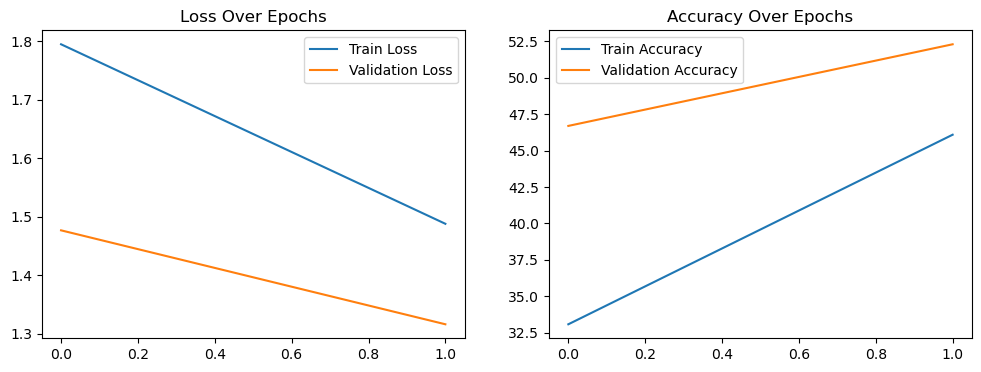

              precision    recall  f1-score   support

       plane       0.66      0.53      0.59      1000
         car       0.70      0.57      0.63      1000
        bird       0.51      0.18      0.26      1000
         cat       0.35      0.22      0.27      1000
        deer       0.44      0.45      0.44      1000
         dog       0.41      0.56      0.48      1000
        frog       0.58      0.64      0.61      1000
       horse       0.48      0.72      0.58      1000
        ship       0.67      0.60      0.63      1000
       truck       0.50      0.75      0.60      1000

    accuracy                           0.52     10000
   macro avg       0.53      0.52      0.51     10000
weighted avg       0.53      0.52      0.51     10000



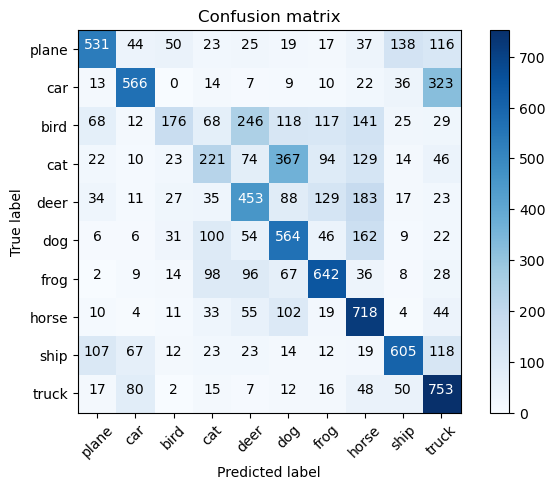

In [3]:
from torchvision import transforms

# Define transforms for the training data and testing data
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the datasets with ImageFolder
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
testloader = DataLoader(testset, batch_size=4, shuffle=False)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = SimpleCNN()

# Set up the training
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Function to plot training progress
def plot_training(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Train the network and save history for plotting
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(2):  # loop over the dataset multiple times
    train_loss, valid_loss = 0.0, 0.0
    correct, total = 0, 0
    
    # Training loop
    net.train()
    for data in trainloader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validation loop
    net.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Saving history for plots
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(100 * correct / total)
    history['val_loss'].append(valid_loss / len(testloader))
    history['val_acc'].append(100 * val_correct / val_total)

    print(f'Epoch {epoch+1}, Train loss: {train_loss / len(trainloader):.2f}, Accuracy: {100 * correct / total:.2f}%, Validation loss: {valid_loss / len(testloader):.2f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%')

plot_training(history)

# Testing the network and plotting confusion matrix
y_pred = []
y_true = []
net.eval()
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Classification Report
print(classification_report(y_true, y_pred, target_names=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']))


Epoch 1, Train loss: 1.37, Accuracy: 50.63%, Validation loss: 1.22, Validation Accuracy: 55.94%
Epoch 2, Train loss: 1.30, Accuracy: 53.16%, Validation loss: 1.21, Validation Accuracy: 56.85%
Epoch 3, Train loss: 1.26, Accuracy: 55.18%, Validation loss: 1.18, Validation Accuracy: 58.15%
Epoch 4, Train loss: 1.23, Accuracy: 56.44%, Validation loss: 1.11, Validation Accuracy: 60.61%
Epoch 5, Train loss: 1.20, Accuracy: 57.41%, Validation loss: 1.12, Validation Accuracy: 60.56%
Epoch 6, Train loss: 1.18, Accuracy: 58.23%, Validation loss: 1.08, Validation Accuracy: 61.59%
Epoch 7, Train loss: 1.17, Accuracy: 58.54%, Validation loss: 1.06, Validation Accuracy: 62.52%
Epoch 8, Train loss: 1.15, Accuracy: 59.49%, Validation loss: 1.09, Validation Accuracy: 61.98%
Epoch 9, Train loss: 1.14, Accuracy: 59.74%, Validation loss: 1.09, Validation Accuracy: 61.80%
Epoch 10, Train loss: 1.13, Accuracy: 59.76%, Validation loss: 1.06, Validation Accuracy: 62.61%


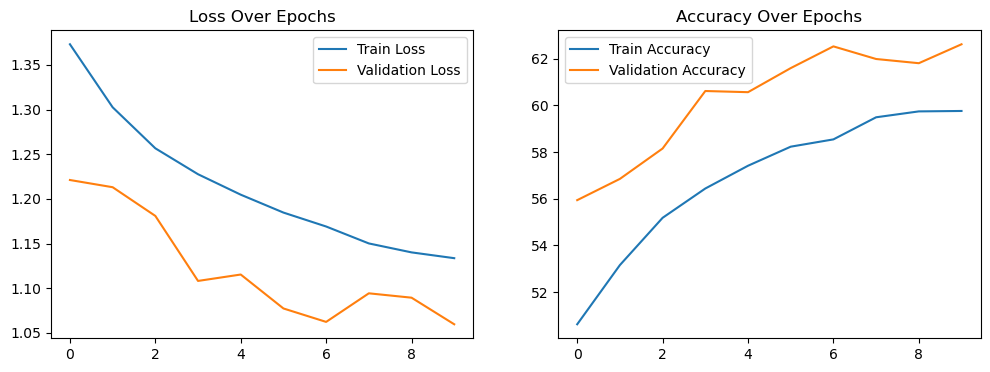

In [4]:
# Previous setup code remains the same...

# Increase the number of epochs
num_epochs = 10  # For example, increase from 2 to 10

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):  # loop over the dataset multiple times
    train_loss, valid_loss = 0.0, 0.0
    correct, total = 0, 0
    
    # Training loop
    net.train()
    for data in trainloader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validation loop
    net.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Saving history for plots
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(100 * correct / total)
    history['val_loss'].append(valid_loss / len(testloader))
    history['val_acc'].append(100 * val_correct / val_total)

    print(f'Epoch {epoch+1}, Train loss: {train_loss / len(trainloader):.2f}, Accuracy: {100 * correct / total:.2f}%, Validation loss: {valid_loss / len(testloader):.2f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%')

plot_training(history)


              precision    recall  f1-score   support

       plane       0.70      0.62      0.66      1000
         car       0.70      0.83      0.76      1000
        bird       0.52      0.49      0.51      1000
         cat       0.39      0.43      0.41      1000
        deer       0.59      0.58      0.58      1000
         dog       0.53      0.49      0.51      1000
        frog       0.72      0.71      0.71      1000
       horse       0.75      0.62      0.68      1000
        ship       0.71      0.74      0.73      1000
       truck       0.67      0.74      0.70      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



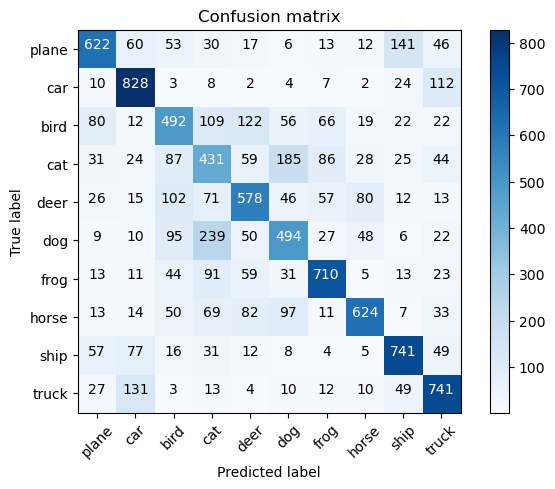

In [5]:
# Testing the network and plotting confusion matrix
y_pred = []
y_true = []
net.eval()
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Classification Report
print(classification_report(y_true, y_pred, target_names=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']))


Epoch 1, Train loss: 1.12, Accuracy: 60.52%, Validation loss: 1.17, Validation Accuracy: 59.54%
Epoch 2, Train loss: 1.12, Accuracy: 60.86%, Validation loss: 1.07, Validation Accuracy: 62.34%
Epoch 3, Train loss: 1.11, Accuracy: 60.86%, Validation loss: 1.05, Validation Accuracy: 62.84%
Epoch 4, Train loss: 1.11, Accuracy: 61.19%, Validation loss: 1.09, Validation Accuracy: 62.12%
Epoch 5, Train loss: 1.10, Accuracy: 61.30%, Validation loss: 1.05, Validation Accuracy: 63.53%
Epoch 6, Train loss: 0.99, Accuracy: 65.23%, Validation loss: 0.94, Validation Accuracy: 67.39%
Epoch 7, Train loss: 0.96, Accuracy: 66.06%, Validation loss: 0.92, Validation Accuracy: 67.82%
Epoch 8, Train loss: 0.95, Accuracy: 66.28%, Validation loss: 0.92, Validation Accuracy: 68.03%
Epoch 9, Train loss: 0.94, Accuracy: 66.87%, Validation loss: 0.90, Validation Accuracy: 68.46%
Epoch 10, Train loss: 0.94, Accuracy: 66.97%, Validation loss: 0.91, Validation Accuracy: 68.33%


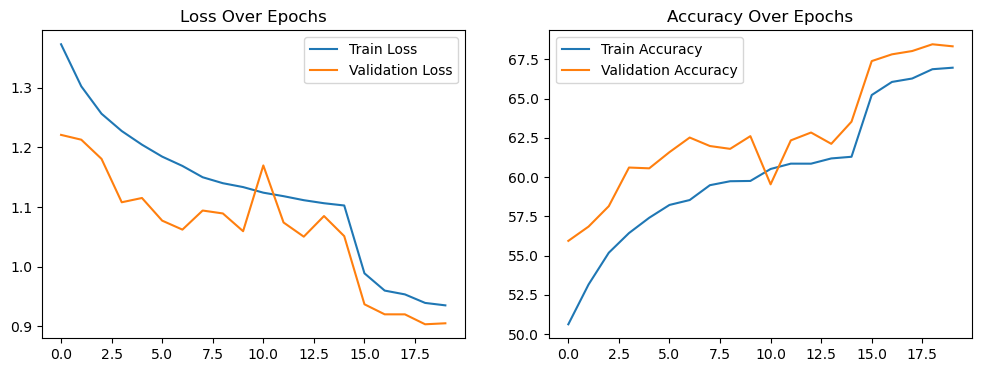

In [6]:
# Assuming you are using SGD as your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Implement a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# In your training loop, add a call to scheduler.step() at the end of each epoch
for epoch in range(num_epochs):
    train_loss, valid_loss = 0.0, 0.0
    correct, total = 0, 0
    
    # Training loop
    net.train()
    for data in trainloader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validation loop
    net.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Saving history for plots
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(100 * correct / total)
    history['val_loss'].append(valid_loss / len(testloader))
    history['val_acc'].append(100 * val_correct / val_total)

    print(f'Epoch {epoch+1}, Train loss: {train_loss / len(trainloader):.2f}, Accuracy: {100 * correct / total:.2f}%, Validation loss: {valid_loss / len(testloader):.2f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%')
    scheduler.step()
    
plot_training(history)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Train loss: 1.73, Accuracy: 50.46%, Validation loss: 1.36, Validation Accuracy: 50.46%
Epoch 2, Train loss: 1.34, Accuracy: 57.04%, Validation loss: 1.16, Validation Accuracy: 57.04%
Epoch 3, Train loss: 1.14, Accuracy: 69.25%, Validation loss: 0.88, Validation Accuracy: 69.25%
Epoch 4, Train loss: 1.03, Accuracy: 69.53%, Validation loss: 0.87, Validation Accuracy: 69.53%
Epoch 5, Train loss: 0.96, Accuracy: 68.74%, Validation loss: 0.88, Validation Accuracy: 68.74%
Epoch 6, Train loss: 0.81, Accuracy: 75.88%, Validation loss: 0.70, Validation Accuracy: 75.88%
Epoch 7, Train loss: 0.78, Accuracy: 76.69%, Validation loss: 0.68, Validation Accuracy: 76.69%
Epoch 8, Train loss: 0.76, Accuracy: 76.39%, Validation loss: 0.68, Validation Accuracy: 76.39%
Epoch 9, Train loss: 0.75, Accuracy: 77.29%, Validation loss: 0.66, Validation Accuracy: 77.29%
Epoch 10, Train loss: 0.74, Accuracy: 77.57%, Validation los

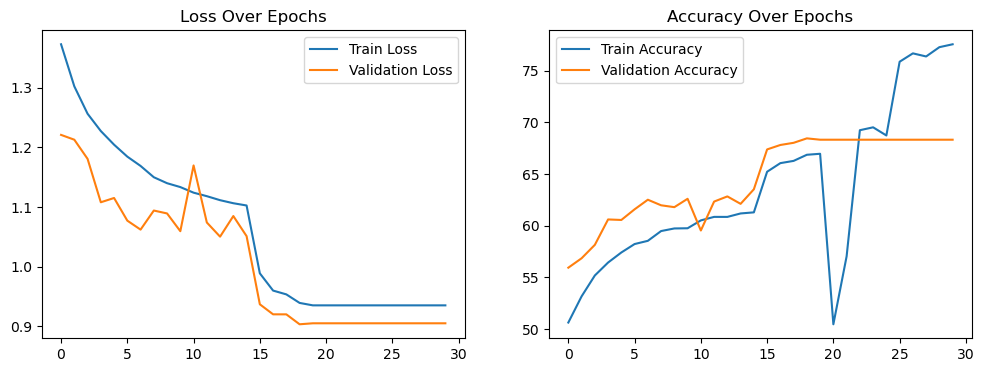

In [8]:
# CNN with an additional convolutional layer and dropout
class ModifiedCNN(nn.Module):
    def __init__(self):
        super(ModifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # New layer
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Adjust input features according to new conv layer
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))  # New layer
        x = x.view(-1, 128 * 4 * 4)  # Adjust flattening
        x = self.dropout(x)  # Dropout layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load the datasets
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
testloader = DataLoader(testset, batch_size=4, shuffle=False)

# Initialize the network
net = ModifiedCNN()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    # Saving history for plots
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(100 * correct / total)
    history['val_loss'].append(valid_loss / len(testloader))
    history['val_acc'].append(100 * val_correct / val_total)
    
    print(f'Epoch {epoch + 1}, Train loss: {running_loss / len(trainloader):.2f}, '
          f'Accuracy: {100 * correct / total:.2f}%, '
          f'Validation loss: {val_loss / len(testloader):.2f}, '
          f'Validation Accuracy: {100 * correct / total:.2f}%')

    scheduler.step()
    
plot_training(history)


Epoch 1, Train loss: 1.79, Accuracy: 51.79%, Validation loss: 1.33, Validation Accuracy: 51.79%
Epoch 2, Train loss: 1.49, Accuracy: 60.35%, Validation loss: 1.09, Validation Accuracy: 60.35%
Epoch 3, Train loss: 1.32, Accuracy: 63.68%, Validation loss: 1.05, Validation Accuracy: 63.68%
Epoch 4, Train loss: 1.19, Accuracy: 67.40%, Validation loss: 0.96, Validation Accuracy: 67.40%
Epoch 5, Train loss: 1.08, Accuracy: 70.91%, Validation loss: 0.83, Validation Accuracy: 70.91%
Epoch 6, Train loss: 0.94, Accuracy: 73.83%, Validation loss: 0.75, Validation Accuracy: 73.83%
Epoch 7, Train loss: 0.90, Accuracy: 74.58%, Validation loss: 0.74, Validation Accuracy: 74.58%
Epoch 8, Train loss: 0.88, Accuracy: 74.58%, Validation loss: 0.73, Validation Accuracy: 74.58%
Epoch 9, Train loss: 0.86, Accuracy: 75.15%, Validation loss: 0.72, Validation Accuracy: 75.15%
Epoch 10, Train loss: 0.85, Accuracy: 75.95%, Validation loss: 0.70, Validation Accuracy: 75.95%


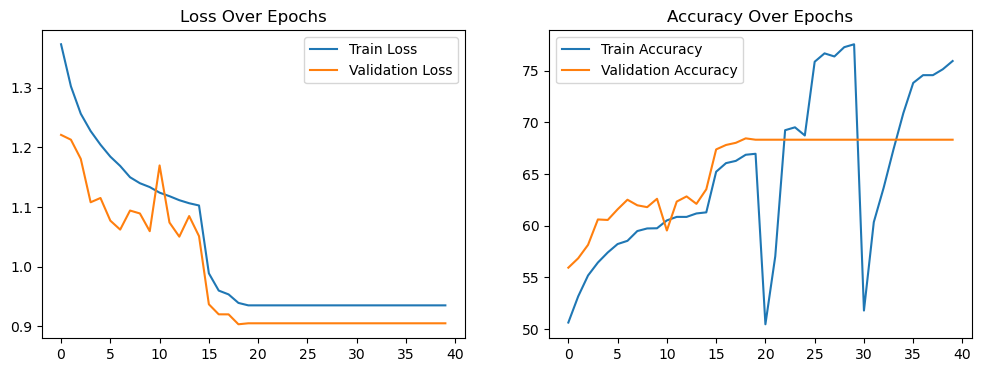

In [9]:
class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    
# Initialize the network
net = AdvancedCNN()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    # Saving history for plots
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(100 * correct / total)
    history['val_loss'].append(valid_loss / len(testloader))
    history['val_acc'].append(100 * val_correct / val_total)
    
    print(f'Epoch {epoch + 1}, Train loss: {running_loss / len(trainloader):.2f}, '
          f'Accuracy: {100 * correct / total:.2f}%, '
          f'Validation loss: {val_loss / len(testloader):.2f}, '
          f'Validation Accuracy: {100 * correct / total:.2f}%')

    scheduler.step()
    
plot_training(history)


              precision    recall  f1-score   support

       plane       0.77      0.80      0.79      1000
         car       0.85      0.91      0.88      1000
        bird       0.68      0.61      0.64      1000
         cat       0.57      0.57      0.57      1000
        deer       0.76      0.69      0.73      1000
         dog       0.66      0.65      0.65      1000
        frog       0.75      0.86      0.80      1000
       horse       0.81      0.79      0.80      1000
        ship       0.86      0.89      0.87      1000
       truck       0.86      0.83      0.85      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



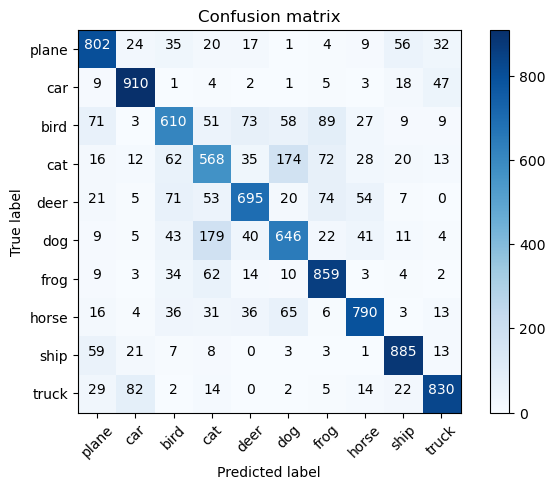

In [10]:
# Testing the network and plotting confusion matrix
y_pred = []
y_true = []
net.eval()
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Classification Report
print(classification_report(y_true, y_pred, target_names=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']))
